In [2]:
import gymnasium as gym
from tetris_gymnasium.envs import Tetris
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
env = gym.make("tetris_gymnasium/Tetris")

In [4]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [41]:
def TetrisTrain():

    partidas = 500
    max_pasos_por_partida = 500  
    alphas = [0.1, 0.3, 0.5] 
    c = 1
    
    env = gym.make("tetris_gymnasium/Tetris")
    n_acciones = env.action_space.n
    
    recompensas_acumuladas = np.zeros((len(alphas), partidas))
    pasos_por_partida = np.zeros((len(alphas), partidas))
    acciones_seleccionadas = np.zeros((len(alphas), partidas, n_acciones))
    Hs_por_epsilon = []

    for i, alpha in enumerate(alphas):
        print(f"\nEntrenando con alpha = {alpha}")
        H = np.zeros(n_acciones)
        
        for partida in range(partidas):
            acciones_count = np.zeros(n_acciones)
            
            pi = softmax(H)
            recompensas = []
            obs, info = env.reset(seed=42)
            recompensa_total = 0
            pasos = 0
            terminado = False
            
            while not terminado and pasos < max_pasos_por_partida:
                accion = np.random.choice(n_acciones, 1, p=pi)[0]
                obs, recompensa, terminado, truncado, info = env.step(accion)
                if recompensa == 0:
                    recompensa = 0.01
                recompensas.append(recompensa)
                recompesna_media = np.mean(recompensas)

                for j in range(n_acciones):
                    if j == accion:
                        H[j] += alpha * (recompensa - recompesna_media) * (1 - pi[j])
                    else:
                        H[j] -= alpha * (recompensa - recompesna_media) * (pi[j])
                
                pi = softmax(H)

                acciones_count[accion] += 1
                recompensa_total += recompensa
                pasos += 1

                if truncado:
                    terminado = True
            
            recompensas_acumuladas[i, partida] = recompensa_total
            pasos_por_partida[i, partida] = pasos
            acciones_seleccionadas[i, partida] = acciones_count
            
            if (partida + 1) % 100 == 0:
                print(f"  Partida {partida + 1}/{partidas} - "
                      f"Recompensa: {recompensa_total:.2f}, "
                      f"Pasos: {pasos}")
        Hs_por_epsilon.append(H.copy()) 
    env.close()
    
    return {
        'alphas': alphas,
        'recompensas_acumuladas': recompensas_acumuladas,
        'pasos_por_partida': pasos_por_partida,
        'acciones_seleccionadas': acciones_seleccionadas,
        'n_acciones': n_acciones,
        'Hs_por_epsilon': Hs_por_epsilon
    }

In [22]:
def Analisis(resultados):

    alphas = resultados['alphas']
    recompensas = resultados['recompensas_acumuladas']
    pasos = resultados['pasos_por_partida']
    acciones = resultados['acciones_seleccionadas']
    n_acciones = resultados['n_acciones']

    print("\n" + "="*60)
    print("RESULTADOS DEL ENTRENAMIENTO")
    print("="*60)
    
    for i, eps in enumerate(alphas):
        recomp_media = np.mean(recompensas[i])
        recomp_std = np.std(recompensas[i])
        pasos_media = np.mean(pasos[i])
        pasos_std = np.std(pasos[i])
        
        print(f"\nEpsilon = {eps}:")
        print(f"  Recompensa promedio: {recomp_media:.2f} - {recomp_std:.2f}")
        print(f"  Pasos promedio: {pasos_media:.2f} - {pasos_std:.2f}")
        print(f"  Mejor partida: {np.max(recompensas[i]):.2f}")
        print(f"  Peor partida: {np.min(recompensas[i]):.2f}")

    print(f"\n" + "="*40)
    print("ANÁLISIS DE ACCIONES")
    print("="*40)
    
    for i, eps in enumerate(alphas):
        acciones_totales = np.sum(acciones[i], axis=0)
        acciones_promedio = acciones_totales / len(recompensas[i])
        
        print(f"\nEpsilon = {eps} - Uso promedio de acciones:")
        for j in range(n_acciones):
            porcentaje = (acciones_promedio[j] / np.sum(acciones_promedio)) * 100
            print(f"  Acción {j}: {acciones_promedio[j]:.1f} veces ({porcentaje:.1f}%)")
    
    return recompensas, pasos

In [ ]:
def Visualizacion(recompensas, pasos, alphas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    
    for i, alp in enumerate(alphas):
        ax1.plot(recompensas[i], label=f'a = {alp}', alpha=0.7)
    ax1.set_xlabel('Partida')
    ax1.set_ylabel('Recompensa Acumulada')
    ax1.set_title('Recompensas por Partida')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    for i, alp in enumerate(alphas):
        ax2.plot(pasos[i], label=f'a = {alp}', alpha=0.7)
    ax2.set_xlabel('Partida')
    ax2.set_ylabel('Pasos por Partida')
    ax2.set_title('Duración de Partidas')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [24]:
print(f"Número de acciones disponibles: {env.action_space.n}")

print("Acciones disponibles:")
actions_obj = env.unwrapped.actions
for attr_name in dir(actions_obj):
    if not attr_name.startswith('_') and hasattr(actions_obj, attr_name):
        action_value = getattr(actions_obj, attr_name)
        if isinstance(action_value, int):
            print(f"  {attr_name}: {action_value}")
print("Recompensas:", env.unwrapped.rewards)

Número de acciones disponibles: 8
Acciones disponibles:
  hard_drop: 5
  move_down: 2
  move_left: 0
  move_right: 1
  no_op: 7
  rotate_clockwise: 3
  rotate_counterclockwise: 4
  swap: 6
Recompensas: RewardsMapping(alife=0.01, clear_line=1, game_over=-2, invalid_action=-0.1)


In [46]:
env.unwrapped.rewards.alife = -0.01
env.unwrapped.rewards.clear_line = 1
env.unwrapped.rewards.game_over = -2
env.unwrapped.rewards.invalid_action = -0.1
print("Recompensas:", env.unwrapped.rewards)

Recompensas: RewardsMapping(alife=-0.01, clear_line=1, game_over=-2, invalid_action=-0.1)


Iniciando entrenamiento del agente Tetris con método acción-valor...

Entrenando con alpha = 0.1
  Partida 100/500 - Recompensa: -0.95, Pasos: 106
  Partida 200/500 - Recompensa: -0.55, Pasos: 146
  Partida 300/500 - Recompensa: -0.94, Pasos: 107
  Partida 400/500 - Recompensa: -0.34, Pasos: 167
  Partida 500/500 - Recompensa: -1.17, Pasos: 84

Entrenando con alpha = 0.3
  Partida 100/500 - Recompensa: -0.77, Pasos: 124
  Partida 200/500 - Recompensa: -0.88, Pasos: 113
  Partida 300/500 - Recompensa: -0.55, Pasos: 146
  Partida 400/500 - Recompensa: -0.35, Pasos: 166
  Partida 500/500 - Recompensa: -0.59, Pasos: 142

Entrenando con alpha = 0.5
  Partida 100/500 - Recompensa: -0.80, Pasos: 121
  Partida 200/500 - Recompensa: -0.85, Pasos: 116
  Partida 300/500 - Recompensa: -0.91, Pasos: 110
  Partida 400/500 - Recompensa: -0.89, Pasos: 112
  Partida 500/500 - Recompensa: -0.13, Pasos: 188

RESULTADOS DEL ENTRENAMIENTO

Epsilon = 0.1:
  Recompensa promedio: -0.93 - 0.33
  Pasos promedio

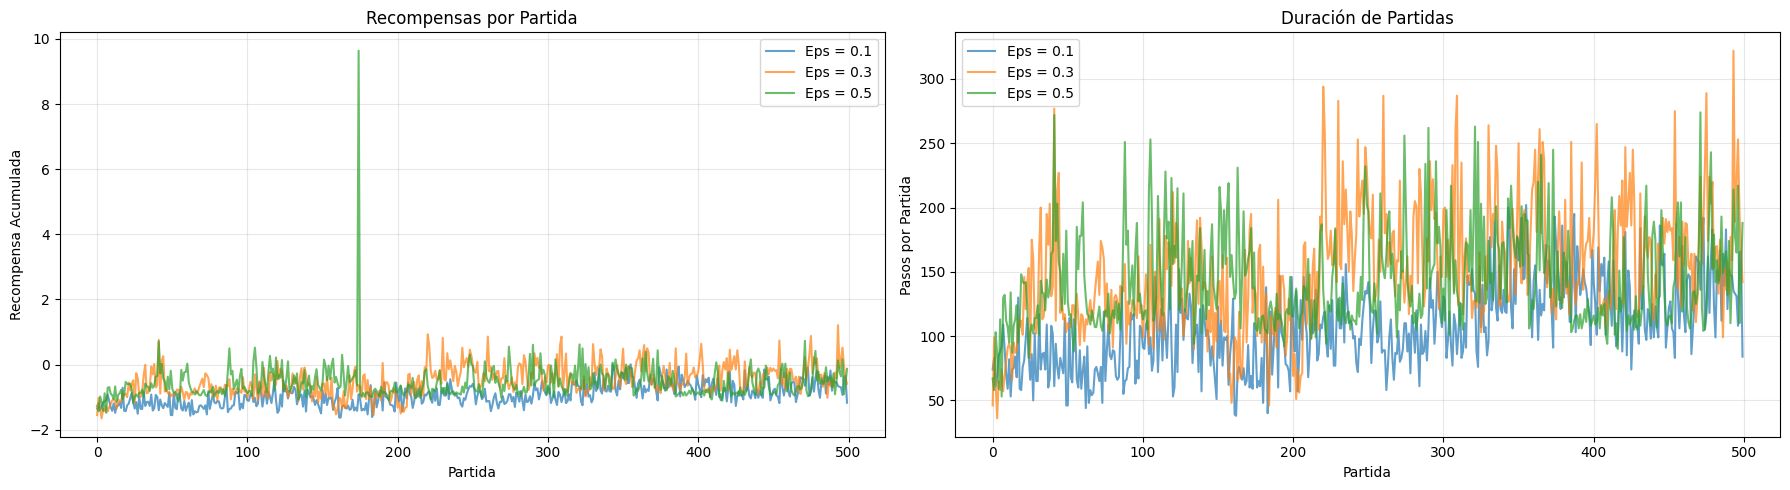


Entrenamiento completado!


In [42]:
print("Iniciando entrenamiento del agente Tetris con método acción-valor...")

resultados = TetrisTrain()
recompensas, pasos = Analisis(resultados)
Visualizacion(recompensas, pasos, resultados['alphas'])

print("\nEntrenamiento completado!")

In [43]:
resultados['Hs_por_epsilon']

[array([ 0.85835856,  0.49307907, -0.71853847, -1.69556456, -1.56451167,
        -1.11762637,  2.25547176,  1.48933169]),
 array([ 3.64253006,  5.41949294, -2.31560571, -2.47912356, -1.88659166,
        -2.66617594,  1.43368086, -1.148207  ]),
 array([ 3.69024779,  4.90064596, -1.8714378 , -0.90900263, -1.65432798,
        -2.8524145 , -1.24767027, -0.05604058])]

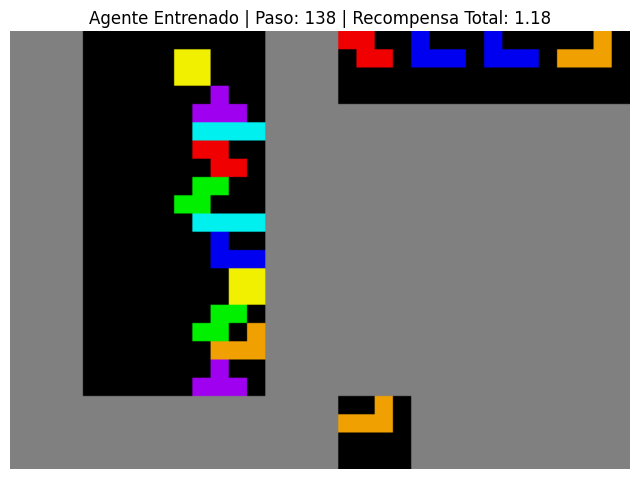


¡Juego terminado!
Pasos totales: 139
Recompensa total: -0.82


In [50]:
def VisualizarAgenteEntrenado(H_table, alpha_usado=0, max_pasos=500):
    """
    Visualiza un juego usando una tabla Q ya entrenada
    """
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    import time
    
    env = gym.make("tetris_gymnasium/Tetris", render_mode="rgb_array")
    
    obs, info = env.reset(seed=42)
    recompensa_total = 0
    pasos = 0
    terminado = False
    
    print(f"Iniciando juego con agente entrenado (epsilon original: {epsilon_usado})")
    print(f"Tabla Q: {H_table}")
    
    while not terminado and pasos < max_pasos:
        # Renderizar el frame
        frame = env.render()
        
        # Mostrar en matplotlib
        plt.figure(figsize=(8, 10))
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Agente Entrenado | Paso: {pasos} | Recompensa Total: {recompensa_total:.2f}')
        
        clear_output(wait=True)
        plt.show()
        # -------------------------------------
        accion = np.random.choice(len(H_table), 1, p=softmax(H_table))[0]
        obs, recompensa, terminado, truncado, info = env.step(accion)
        if recompensa == 0:
            recompensa = 0.01
        
        recompensa_total += recompensa
        pasos += 1

        if truncado:
            terminado = True
        # -------------------------------------
        
        time.sleep(0.3)
    
    print(f"\n¡Juego terminado!")
    print(f"Pasos totales: {pasos}")
    print(f"Recompensa total: {recompensa_total:.2f}")
    
    env.close()
    
    return recompensa_total, pasos

Hs_por_epsilon = resultados['Hs_por_epsilon']
indice_epsilon = 1
epsilon_usado = 0.3

resultado = VisualizarAgenteEntrenado(
    H_table=Hs_por_epsilon[indice_epsilon], 
    alpha_usado=epsilon_usado
)